In [1]:
import os
import pandas as pd
import numpy as np

import sys
sys.path.insert(0, '../../src')
from utils import preprocession as prep
from utils import visualization as vis

import WassersteinTSNE as WT
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.decomposition import PCA

from numpy.random import Generator, PCG64
rng = Generator(PCG64(seed=0))

In [2]:
N = 60 # number of users per party
K = 50 # number of statements
D = 4  # number of choices per statement

x_min, x_max = -1,1
y_min, y_max = -1,1

# Create the folder if it doesn't exist
folder_name = f"../../data/Synthetic_{N}_{K}"
os.makedirs(folder_name, exist_ok=True)

In [3]:
test_mask = rng.binomial(1, 0.15, 5*N).astype(bool)

## Users

In [4]:
means   = [[-.5,-.5],[-.5,.5],[.5,-.5],[.5,.5],[0,0]]
covs    = [WT.CovarianceMatrix(np.eye(2), np.array([.025,.025])) for i in means]
classes = [WT.GaussianDistribution(m,c) for m,c in zip(means, covs)]

users  = pd.concat([pd.DataFrame(gaussian.samples(seed=rng.integers(100), size=N), columns=['x' , 'y']) for gaussian in classes]).reset_index(drop=True)
users['party'] = (users.index / N).astype(int)
users['color'] = 'C'+users['party'].astype(str)

users.loc[~test_mask].to_csv(f'{folder_name}/train_candidates.csv')
users.loc[test_mask].to_csv(f'{folder_name}/test_candidates.csv')

users

,x,y,party,color
0,-0.590926,-0.485443,0,C0
1,-0.833900,-0.720892,0,C0
2,-0.619618,-0.535143,0,C0
3,-0.383337,-0.482217,0,C0
4,-0.567466,-0.550194,0,C0
...,...,...,...,...
295,0.072860,-0.332997,4,C4
296,0.410137,0.091080,4,C4
297,-0.071746,-0.109329,4,C4
298,-0.090319,-0.021694,4,C4


In [5]:
a, b = users.x.idxmax(), users.y.idxmin()
users.iloc[[a,b]]

,x,y,party
172,0.843686,-0.390957,2
23,-0.677759,-0.914574,0


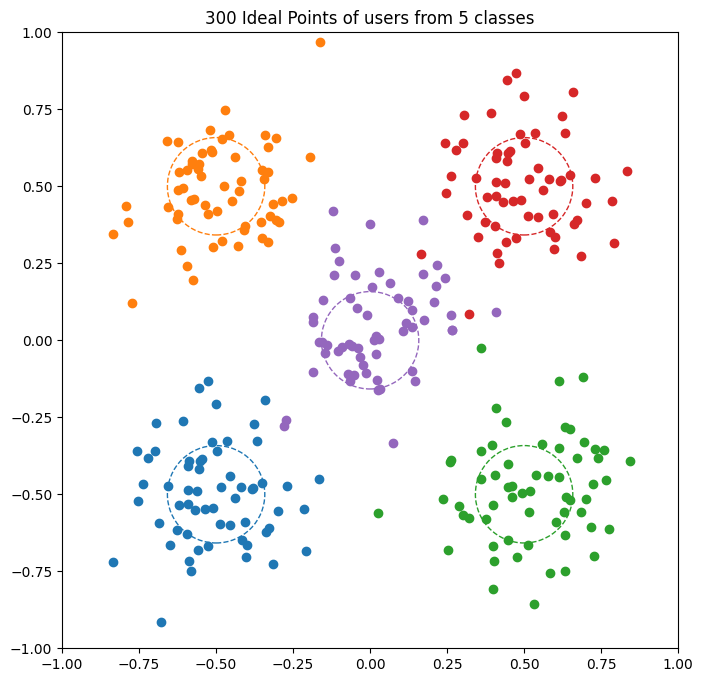

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

for i, G in enumerate(classes):
    x,y,_ = users.loc[users['party'] == i].values.T
    ax.scatter(x,y, color='C'+str(i))
    WT.plotGaussian(G, size=0, STDS=[1], color='C'+str(i), ax=ax)

ax.set(xlim=[-1,1],
       ylim=[-1,1],
       aspect='equal',
       title=f'{N*5} Ideal Points of users from 5 classes'
      )


plt.show()

## Statements

In [7]:
statements = rng.uniform(-1, 1, (K, 4))
statements = pd.DataFrame(statements, columns=['x0', 'y0', f'x{D-1}', f'y{D-1}'])

f = lambda row: np.hstack([k*row.loc[[f'x{D-1}',f'y{D-1}']].values+(1-k)*row.loc[['x0','y0']].values for k in np.linspace(0,1,D)[1:-1]])
statements[list(map( lambda i: i[1]+str(i[0]//2+1), zip(range((D-2)*2), ['x', 'y']*(D-2))))] = statements.apply(f, axis=1, result_type='expand')
statements.to_csv(f'{folder_name}/statements.csv')

statements = statements.sort_index(axis=1)
statements.head()

,x0,x1,x2,x3,y0,y1,y2,y3
0,0.422974,0.499287,0.575601,0.651914,0.138052,0.113475,0.088898,0.064321
1,0.626488,0.318029,0.009569,-0.298890,0.994021,0.443361,-0.107298,-0.657957
2,-0.216650,-0.184948,-0.153245,-0.121542,0.506100,0.396320,0.286540,0.176760
3,-0.745283,-0.643467,-0.541651,-0.439835,0.452247,0.095243,-0.261761,-0.618765
4,0.725900,0.473599,0.221299,-0.031002,0.128826,0.351766,0.574707,0.797648


[Text(0.5, 1.0, 'Lines with color gradient'), (-1.0, 1.0), (-1.0, 1.0), None]

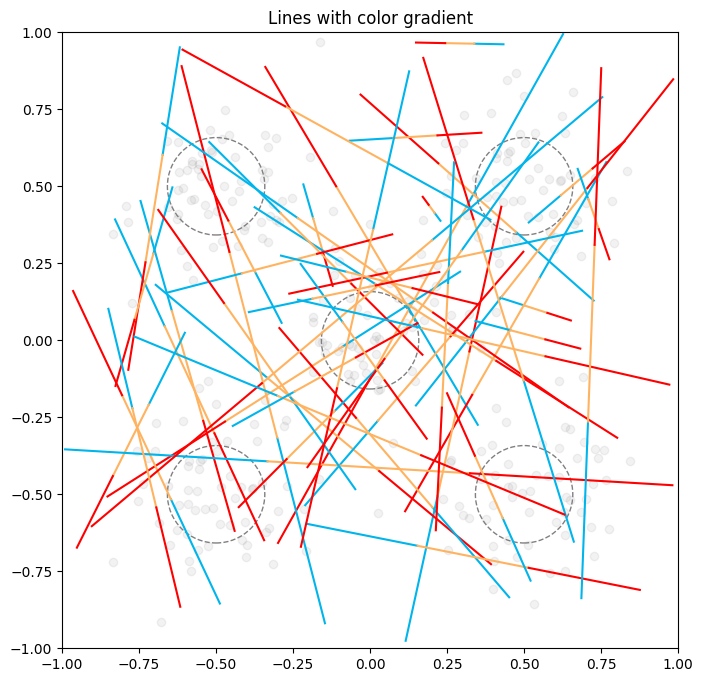

In [8]:
colormap = mpl.colormaps['rainbow']

def plot_gradient_line(row):
    # Reshape the object's data into 4 points with x,y coordinates
    points = row.values[:2*D].reshape(2, D).T

    #plt.scatter(points[0:2, 0], points[0:2, 1], color=colormap(0.0), marker='s', s=10)

    # Plot lines between the points with color changing from red to blue
    for i in range(D-1):  # since there are 4 points, there will be 3 segments between them
        plt.plot(points[i:i+2, 0], points[i:i+2, 1], color=colormap((i+.5)/(D-2)))
        #plt.scatter(points[i+1:i+3, 0], points[i+1:i+3, 1], color=colormap((i+1)/(D-1)), marker='s', s=10)

fig, ax = plt.subplots(figsize=(8, 8))

for i, G in enumerate(classes):
    x,y,_ = users.loc[users['party'] == i].values.T
    ax.scatter(x,y, color='gray', alpha=0.1)
    WT.plotGaussian(G, size=0, STDS=[1], color='gray', ax=ax)

statements.apply(plot_gradient_line, axis=1)

ax.set(title='Lines with color gradient',
       xlim=[-1,1],
       ylim=[-1,1],
       aspect='equal'
      )

In [9]:
options = []
for i in range(D):
    options.append( WT.EuclideanDistance(users[['x','y']], statements.iloc[:,[i, i+D]]) )

reactions = np.array(options).argmin(axis=0).astype(int)
reactions = pd.DataFrame(reactions/(D-1), columns=statements.index, index=users.index).round(2)
reactions

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,1.00,1.0,1.00,0.67,0.67,0.33,0.67,1.00,0.33,...,1.00,0.33,0.67,1.00,0.00,0.00,0.67,0.00,0.00,0.33
1,0.0,1.00,1.0,1.00,0.67,1.00,0.00,1.00,1.00,0.00,...,1.00,0.00,0.67,1.00,0.00,0.00,0.67,0.00,0.00,0.00
2,0.0,1.00,1.0,1.00,0.67,0.67,0.33,0.67,1.00,0.33,...,1.00,0.33,0.67,1.00,0.00,0.00,0.67,0.00,0.00,0.00
3,0.0,1.00,1.0,1.00,0.33,1.00,0.00,0.33,1.00,0.33,...,1.00,0.33,0.67,1.00,0.00,0.00,0.67,0.00,0.00,0.33
4,0.0,1.00,1.0,1.00,0.67,1.00,0.33,0.67,1.00,0.33,...,1.00,0.33,0.67,1.00,0.00,0.00,0.67,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.67,1.0,1.00,0.33,1.00,0.00,0.00,1.00,0.33,...,0.67,0.67,0.67,0.67,0.67,0.67,1.00,0.67,0.33,0.33
296,0.0,0.33,1.0,0.67,0.33,0.67,0.33,0.00,0.33,0.67,...,0.33,0.67,0.33,0.33,1.00,1.00,0.67,1.00,0.67,0.67
297,0.0,0.67,1.0,0.67,0.33,0.67,0.33,0.00,0.67,0.67,...,0.67,0.33,0.33,0.67,0.67,0.33,0.67,0.33,0.33,0.33
298,0.0,0.67,1.0,0.67,0.67,0.67,0.33,0.00,0.67,0.67,...,0.67,0.33,0.33,0.67,0.67,0.33,0.33,0.33,0.00,0.33


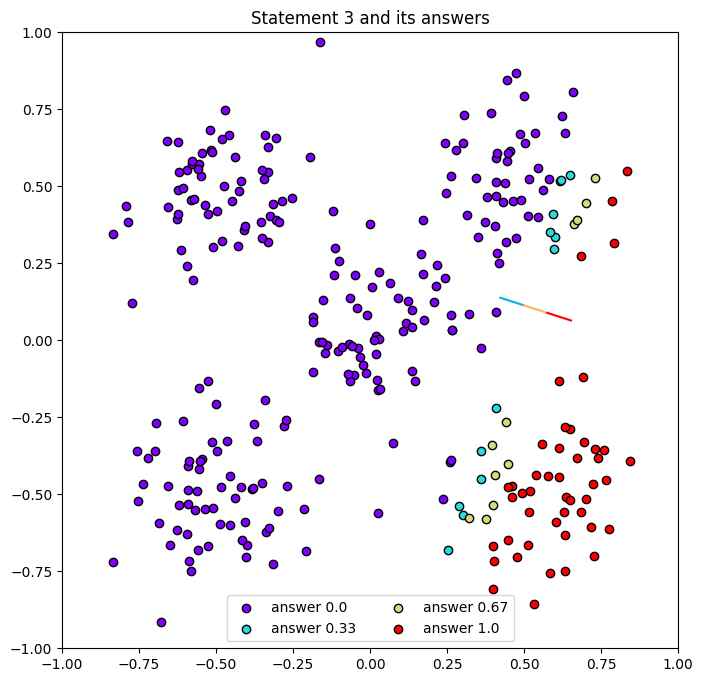

In [10]:
def plot_multiclass_feature(i, R, title=f"Statement {i} and its answers"):
    fig, ax = plt.subplots(figsize=(8,8))
    data = R.iloc[:,i]
    
    # Plot the data points
    for c in sorted(data.unique()):
        mask = data == c
        ax.scatter(users.loc[mask, 'x'], users.loc[mask, 'y'], color=colormap(c), edgecolors='k', label='answer '+str(c))
   
    plot_gradient_line(statements.iloc[i,:])
    
    ax.set(title=title,
       xlim=[-1,1],
       ylim=[-1,1],
       aspect='equal'
      )
    
    ax.legend(ncol=2)
    
plot_multiclass_feature(0, reactions)

## Binary Statements

In [11]:
binary_reactions = reactions.round().astype(int)
binary_reactions

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,1,1,1,1,1,0,1,1,0,...,1,0,1,1,0,0,1,0,0,0
1,0,1,1,1,1,1,0,1,1,0,...,1,0,1,1,0,0,1,0,0,0
2,0,1,1,1,1,1,0,1,1,0,...,1,0,1,1,0,0,1,0,0,0
3,0,1,1,1,0,1,0,0,1,0,...,1,0,1,1,0,0,1,0,0,0
4,0,1,1,1,1,1,0,1,1,0,...,1,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,1,1,1,0,1,0,0,1,0,...,1,1,1,1,1,1,1,1,0,0
296,0,0,1,1,0,1,0,0,0,1,...,0,1,0,0,1,1,1,1,1,1
297,0,1,1,1,0,1,0,0,1,1,...,1,0,0,1,1,0,1,0,0,0
298,0,1,1,1,1,1,0,0,1,1,...,1,0,0,1,1,0,0,0,0,0


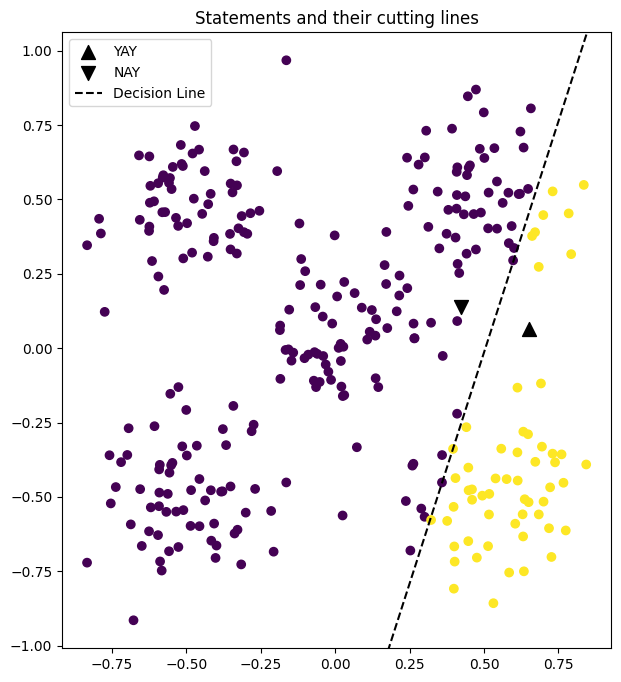

In [12]:
def plot_binary_feature(i, R, title='Statements and their cutting lines'):
    ax = vis.plotEmbedding(users, c=R.iloc[:,i])
    vis.plotQuestion(statements.loc[i,[f'x{D-1}','x0',f'y{D-1}','y0']], ax=ax)
    ax.set(title=title)
    ax.legend()
     
plot_binary_feature(0, binary_reactions)

## PCA Projection

Text(0.5, 1.0, 'PCA with original data')

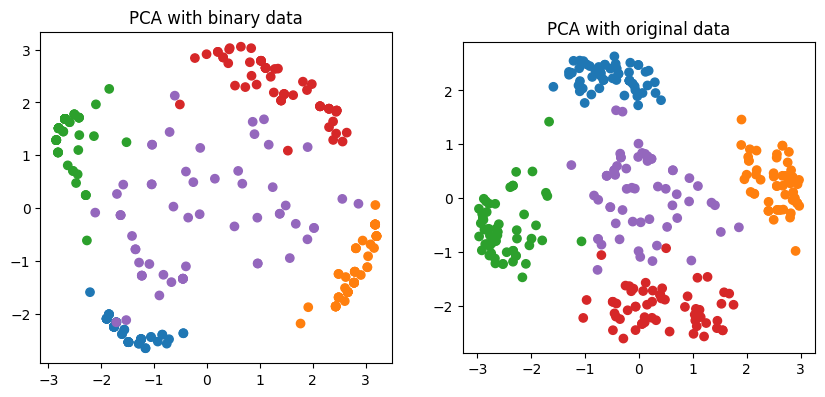

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

pca = PCA(n_components=2)
X = pca.fit_transform(binary_reactions)
E = pd.DataFrame(X,
                 index = users['party'], 
                 columns=['X','Y'])
_ = vis.plotEmbedding(E, ax=ax1, c='C'+users.party.astype(str))
ax1.set_title('PCA with binary data')

pca = PCA(n_components=2)
X = pca.fit_transform(reactions)
E = pd.DataFrame(X,
                 index = users['party'], 
                 columns=['X','Y'])
_ = vis.plotEmbedding(E, ax=ax2, c='C'+users.party.astype(str))
ax2.set_title('PCA with original data')

## Sparsity

### Save Reactions

In [14]:
sub_folder_bin = f'{folder_name}/Binary'
os.makedirs(sub_folder_bin, exist_ok=True)
sub_folder_ori = f'{folder_name}/Original'
os.makedirs(sub_folder_ori, exist_ok=True)

for p in range(0,100,10):
    reactions_missing = pd.DataFrame(reactions.apply(prep.sparsen, p=p/100, generator=rng, axis=1, result_type='expand'),
                                     columns=statements.index, index=users.index)

    reactions_missing.loc[test_mask].to_csv(f'{sub_folder_ori}/test_reactions_{p}.csv')
    reactions_missing.loc[~test_mask].to_csv(f'{sub_folder_ori}/train_reactions_{p}.csv')

    round(reactions_missing).loc[test_mask].to_csv(f'{sub_folder_bin}/test_reactions_{p}.csv')
    round(reactions_missing).loc[~test_mask].to_csv(f'{sub_folder_bin}/train_reactions_{p}.csv')

### Check data

In [15]:
users = pd.read_csv(f'{folder_name}/train_candidates.csv', index_col=0)
users

,x,y,party
0,-0.590926,-0.485443,0
1,-0.833900,-0.720892,0
2,-0.619618,-0.535143,0
3,-0.383337,-0.482217,0
4,-0.567466,-0.550194,0
...,...,...,...
294,0.006560,0.173706,4
295,0.072860,-0.332997,4
296,0.410137,0.091080,4
298,-0.090319,-0.021694,4


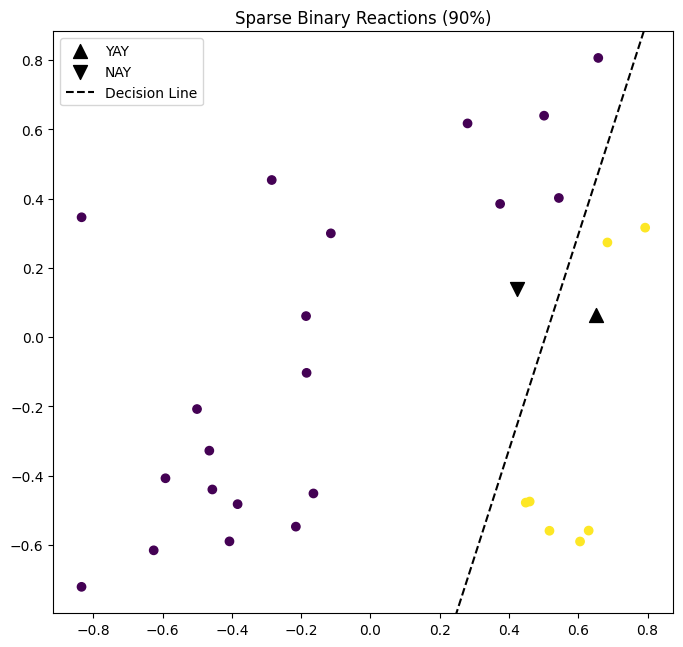

In [16]:
p = 90
reactions_missing = pd.read_csv(f'{sub_folder_bin}/train_reactions_{p}.csv', index_col=0)
reactions_missing.columns = map(int, reactions_missing.columns)
plot_binary_feature(0, reactions_missing, f'Sparse Binary Reactions ({p}%)')

In [17]:
reactions_missing

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,1.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN
3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
295,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0
298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
